**AI PROJECT: Garbage Classification using CNN**

**Group Members:**

1. 20L-1184 Section 6A

2. 20L-1210 Section 6A

3. 20L-2164 Section 6D

<Note: Run this project in Google Collaboratory since it uses google drive>

**DATASET LINK**: https://drive.google.com/drive/folders/1GDSE1CVpuOUZXx9LyQ2kCfESix40-1Ul?usp=sharing


We gathered a dataset containing close to 3000 total images of plastic, metal and paper waste. To use it, you need to create a shortcut of the "Final_Dataset" folder to "My Drive". Upon running the code, you will be asked to choose your google account whose Drive will be mounted.

**Data Pre-Processing:**

This code is performing the following pre-processing steps on the image dataset:

* Reading images using cv2.imread() method
* Converting the color format from BGR to RGB using cv2.COLOR_BGR2RGB method
* Resizing the images to a fixed size (IMG_HEIGHT, IMG_WIDTH) using cv2.resize() method with interpolation=cv2.INTER_AREA
* Converting the images to a numpy array using np.array() method
* Converting the data type of images to float64 using image.astype('float64') method
* Normalizing the pixel values in the range [0, 1] by dividing each pixel value by 255
* Storing the images as numpy arrays in img_data_array
* Reshape image to (200,200,3)
* Storing the class labels in class_name

**Model Training & Testing**

This code segment defines and sets up a Convolutional Neural Network (CNN) model for image classification. Here are the steps it performs:

* The code defines a class called `CNNNet` that inherits from the `nn.Module` class, which is the base class for all neural network modules in PyTorch.
* Inside the `CNNNet` class, the model architecture is defined in the `__init__` method. The architecture consists of two main parts: `cnn_layers` and `linear_layers`.
* The `cnn_layers` are defined using the `nn.Sequential` container, which allows stacking multiple layers sequentially. The layers in `cnn_layers` are as follows:
   - `nn.Conv2d`: A 2D convolutional layer with 3 input channels, 16 output channels, a kernel size of (5, 5), a stride of (2, 2), and padding of (2, 2).
   - `nn.ReLU`: Activation function ReLU (Rectified Linear Unit) is applied element-wise to introduce non-linearity.
   - `nn.MaxPool2d`: A 2D max pooling layer with a kernel size of 2 and stride 2, which reduces the spatial dimensions of the input by taking the maximum value in each pooling region.
   - Another `nn.Conv2d` layer with 16 input channels (output from the previous layer), 3 output channels, a kernel size of (50, 50), and a stride of (1, 1).
   - Another `nn.MaxPool2d` layer with a kernel size of 1 and stride 1, effectively not reducing the spatial dimensions further.
* The `linear_layers` are defined using another `nn.Sequential` container, containing a single `nn.Linear` layer. This layer takes the output from the previous layers and performs a linear transformation.
* The `forward` method of the `CNNNet` class defines the forward pass of the model. It takes an input tensor `x` and passes it through the `cnn_layers` sequentially. Then, the output is reshaped using `x.view(x.size(0), -1)` to flatten the tensor, preserving the batch size but collapsing the spatial dimensions. Finally, the flattened tensor is passed through the `linear_layers` to produce the output.
* After defining the model architecture, an instance of the `CNNNet` class is created and assigned to the `model` variable.
* The code defines an optimizer using stochastic gradient descent (SGD) with a learning rate of 0.0001. The optimizer is initialized with the parameters of the `model` using `model.parameters()`.
* A loss function is defined using cross-entropy loss (`nn.CrossEntropyLoss`). This loss function is commonly used for multi-class classification problems.
* The model is then trained and tested for the given architecture, epochs = 100



In [ ]:
#Importing Necessary files to read Images
import os
import cv2
import numpy as np
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

In [ ]:
# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ROOT_DIR = "gdrive/MyDrive/dataset_final/"


In [ ]:
#Printing random images from the dataset
import os

Training_folder = ROOT_DIR + "training"
Testing_folder = ROOT_DIR + "testing"
os.listdir(Training_folder)
EPOCHS=15


In [ ]:
# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    Training_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=[256, 256],
    color_mode='rgb',
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    Testing_folder,
    labels='inferred',
    label_mode='categorical',
    image_size=[256, 256],
    color_mode='rgb',
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


Found 2923 files belonging to 3 classes.
Found 464 files belonging to 3 classes.


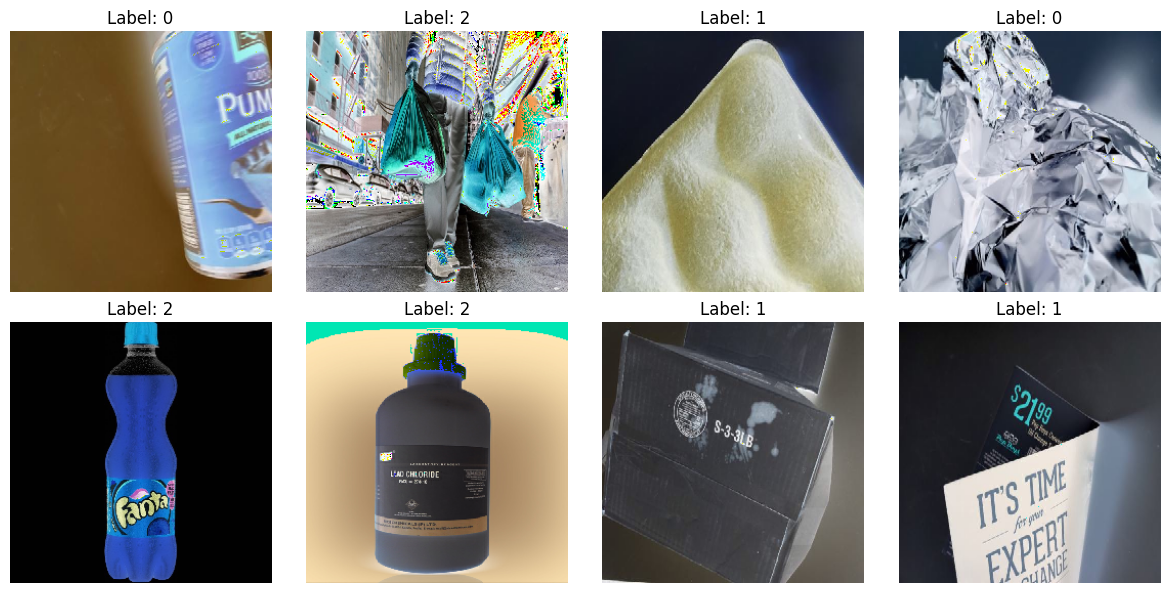

In [ ]:
import matplotlib.pyplot as plt

# Assuming `ds_train_` is your training dataset

# Retrieve a batch of images and labels from the dataset
for images, labels in ds_train_.take(1):
    # Convert one-hot encoded labels to class indices
    class_indices = tf.argmax(labels, axis=1)

    # Display the images and their labels
    fig, axs = plt.subplots(2, 4, figsize=(12, 6))
    axs = axs.flatten()
    for i in range(len(axs)):
        # Convert image tensor to NumPy array and rescale pixel values
        image = (images[i] * 255).numpy().astype(int)

        # Display the image and its corresponding label
        axs[i].imshow(image)
        axs[i].axis('off')
        axs[i].set_title(f"Label: {class_indices[i]}")
    plt.tight_layout()
    plt.show()


Learning rate schedule: 1e-05 to 5e-05 to 1.18e-05


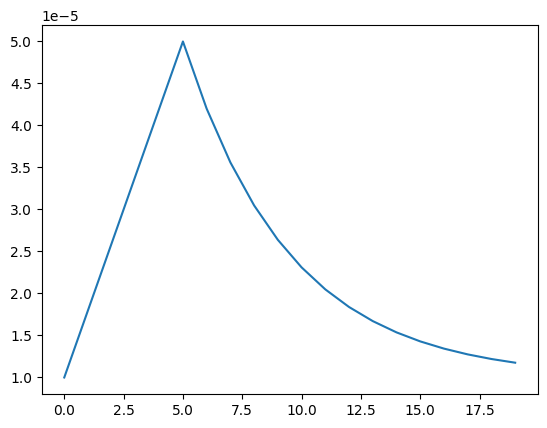

In [ ]:
# Learning Rate Schedule for Fine Tuning #
def exponential_lr(epoch,
                   start_lr = 0.00001, min_lr = 0.00001, max_lr = 0.00005,
                   rampup_epochs = 5, sustain_epochs = 0,
                   exp_decay = 0.8):

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs, sustain_epochs, exp_decay):
        # linear increase from start to rampup_epochs
        if epoch < rampup_epochs:
            lr = ((max_lr - start_lr) /
                  rampup_epochs * epoch + start_lr)
        # constant max_lr during sustain_epochs
        elif epoch < rampup_epochs + sustain_epochs:
            lr = max_lr
        # exponential decay towards min_lr
        else:
            lr = ((max_lr - min_lr) *
                  exp_decay**(epoch - rampup_epochs - sustain_epochs) +
                  min_lr)
        return lr
    return lr(epoch,
              start_lr,
              min_lr,
              max_lr,
              rampup_epochs,
              sustain_epochs,
              exp_decay)

lr_callback = tf.keras.callbacks.LearningRateScheduler(exponential_lr, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [exponential_lr(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))


In [ ]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

In [ ]:
from tensorflow.keras import callbacks
early_stopping = callbacks.EarlyStopping(
    min_delta=0.01, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
base_model = tf.keras.applications.xception.Xception(
  weights='imagenet',
  input_shape=[256,256, 3],
  include_top=False)
base_model.trainable = True
model = keras.Sequential([
    layers.InputLayer(input_shape=[256, 256, 3]),
    # Data Augmentation
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomFlip(mode='vertical'),
    preprocessing.RandomRotation(factor=0.10),
    preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
    base_model,

    # Head
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.BatchNormalization(renorm=True),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(renorm=True),
    layers.Dense(3, activation='softmax'),
])


In [ ]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=EPOCHS,
    callbacks=[lr_callback, early_stopping]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/15
46/46 [==============================] - 93s 1s/step - loss: 0.9045 - categorical_accuracy: 0.5874 - val_loss: 0.8675 - val_categorical_accuracy: 0.6250 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0008100000379979611.
Epoch 2/15
46/46 [==============================] - 57s 1s/step - loss: 0.4125 - categorical_accuracy: 0.8597 - val_loss: 0.7563 - val_categorical_accuracy: 0.7651 - lr: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005060000335611404.
Epoch 3/15
46/46 [==============================] - 56s 1s/step - loss: 0.2397 - categorical_accuracy: 0.9117 - val_loss: 0.5911 - val_categorical_accuracy: 0.8578 - lr: 5.0600e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00023240000449121004.
Epoch 4/15
46/46 [==============================] - 57s 1s/step - loss: 0.1843 - categorical_accuracy: 0.9340 - val_loss: 0.5153 - val_categ

<ipython-input-42-bfa16ecd02c3>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


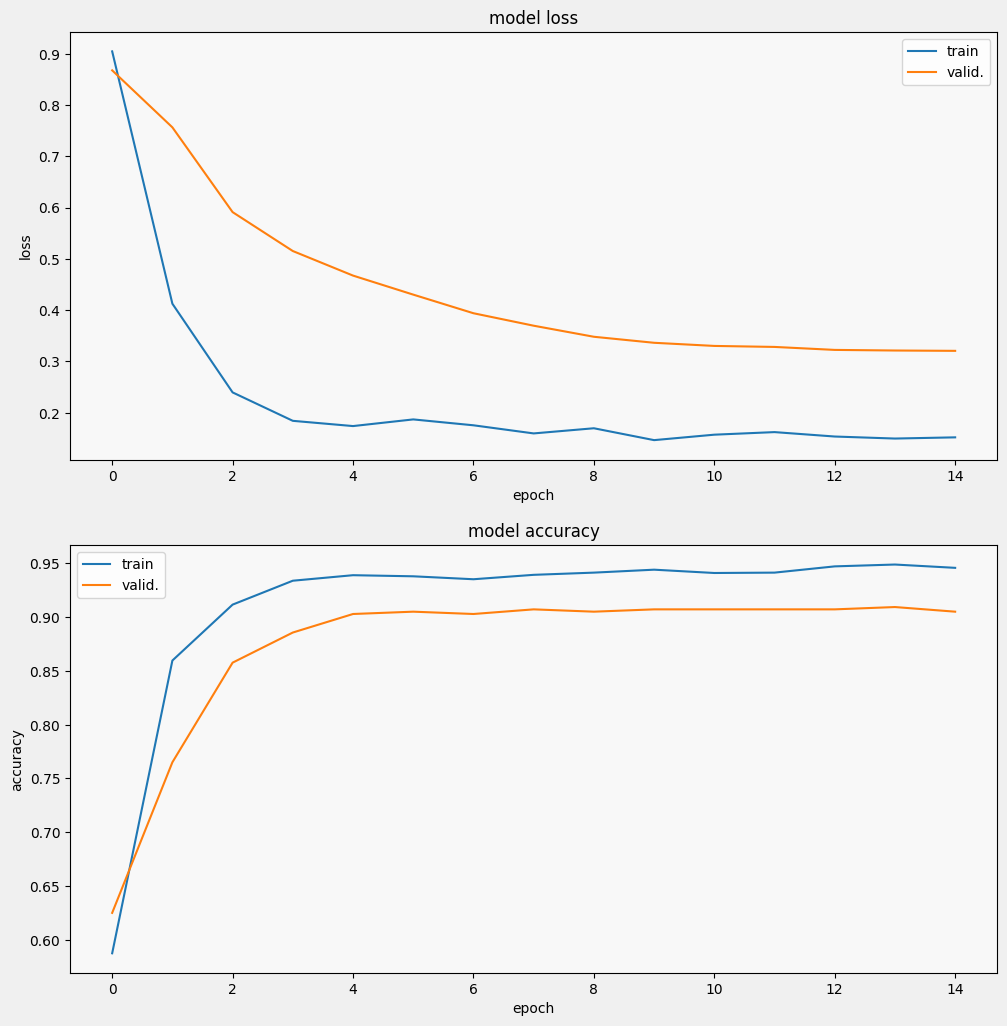

In [ ]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss',
    211,
)
display_training_curves(
    history.history['categorical_accuracy'],
    history.history['val_categorical_accuracy'],
    'accuracy',
    212,
)

In [ ]:
import numpy as np

# Extract the labels from the dataset
labels = np.concatenate([y for x, y in ds_valid_], axis=0)

# Convert the labels from one-hot encoding to class indices
true_labels = np.argmax(labels, axis=1)


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


# Assuming `ds_valid` is your validation dataset
# Assuming `true_labels` is the true labels for the validation data

# Get the predictions for the validation data
predictions = np.argmax(model.predict(ds_valid), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Generate the classification report
report = classification_report(true_labels, predictions)

print("\nClassification Report:")
print(report)


8/8 [==============================] - 3s 303ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        69
           1       0.93      0.93      0.93       212
           2       0.92      0.86      0.89       183

    accuracy                           0.91       464
   macro avg       0.89      0.91      0.90       464
weighted avg       0.91      0.91      0.91       464



In [ ]:
labels

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
accuracy = accuracy_score(
    true_labels,
    predictions)
score = f1_score(
    true_labels,
    predictions,
    labels=np.argmax(labels,axis=1),
    average='weighted',
)
precision = precision_score(
    true_labels,
    predictions,
    labels=np.argmax(labels,axis=1),
    average='weighted',
)
recall = recall_score(
    true_labels,
    predictions,
    labels=np.argmax(labels,axis=1),
    average='weighted',
)

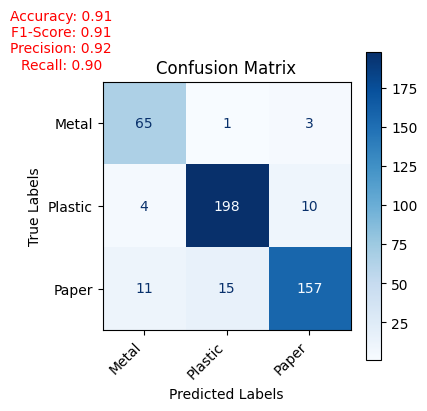

In [ ]:
# Define the class dictionary
class_dict = {
    "0": "Metal",
    "1": "Paper",
    "2": "Plastic"
}

# Calculate metrics
classification_rep = classification_report(true_labels, predictions, target_names=class_dict.values(), output_dict=True)


# Plot the confusion matrix with metrics
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_dict.values())
fig, ax = plt.subplots(figsize=(4, 4))
ax = plt.gca()
disp.plot(ax=ax, cmap='Blues')

ax.text(-1,-1, f'Accuracy: {accuracy:.2f}\nF1-Score: {score:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}', ha='center', va='center', color='red')

# Set plot labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [ ]:
model.save('/content')
